<a href="https://colab.research.google.com/github/anthonyhu25/Variance-Reduction-Code/blob/main/Variance_Reduction_Example_1_(2_4_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from numpy import random
from numpy import linalg
import math
import scipy
import scipy.stats
import matplotlib.pyplot as plt
from scipy.stats import rv_continuous, rv_discrete
from scipy.stats._distn_infrastructure import rv_frozen
from scipy.special import logsumexp
import scipy.integrate
import warnings
import sys
import statistics
import pandas as pd
from IPython.display import display, Math, HTML

# Example 1 (Normal target distribution with normal distribution and student-t distribution proposals)

In this example, we are estimating the expected value of $F(x) = x$, with the target distribution $\pi(x)\sim N\bigl(x\mid 0,1 )$. We will use two proposal distributions: $N\bigl(y\mid 0,\sigma^2\bigr)$ and a 0-mean student-t distribution with $t_\nu (y)$. Note that $\sigma^2$ and $\nu$ are not fixed in either proposal distribution. We will simulate the posterior with different values of each parameter to see how $\mu_{n,IMCV}$ (the posterior mean of the independent Metropolis-Hastings Algorithm with the control variate for $n$ samples) changes as we increase both parameters.

For each possible values of $\sigma^2$ and $\nu$, we will simulate 5000 values (as noted in the paper) for 20 times. Then, we will find $\mu_{n, MC*}$ (the mean of the conditional Monte Carlo estimator for $n$ samples) of the algorithm, and calculate the VRF (variance reduciton factor) using the below formula:

$$VRF =
  \frac{%
    \displaystyle
    \sum_{i=1}^T
      \Bigl(
        \mu_{n,\mathrm{MC}^*}^{(i)}
        \;-\;
        \frac{1}{T}\,\sum_{j=1}^T \mu_{n,\mathrm{MC}^*}^{(j)}
      \Bigr) ^2
  }{%
    \displaystyle
    \sum_{i=1}^T
      \Bigl(
        \mu_{n,\mathrm{IMCV}}^{(i)}
        \;-\;
        \frac{1}{T}\,\sum_{j=1}^T \mu_{n, \mathrm{IMCV}^*}^{(j)}
      \Bigr) ^2
  }
$$


Note that we need to explicitly calculate $E_{q}(F)$, where $F(x) = x$.
Since $q(y)$ are the $N\bigl(y\mid 0,\sigma^2\bigr)$ and the $0$-mean student-t distribution with $t_\nu (y)$, we just need to find the first moment of these two distributions. However, since both distributions have 0 mean, then $𝔼_{q}(F) = 𝔼_{q}(x) =  0$ for both proposal distributions. Note that $f(x) ∝ \frac{-\mu x^2 }{2σ^2}$, where $\mu$ and $\sigma$ are parameters of $\pi(x)$. So, $f(x)$ simplifies to $\frac{-x^2}{2}$, for all values drawn from $\pi(x)$. Also note that both proposal densities are greater than 0, and hence we do not have to worry about the case when $q(y)$ equals 0.

In [ ]:
def univariate_independent_metro(n_simulations, T_iterations, burn_in, pi_distribution, q_distribution, F_function):
  # First check to see if pi and q are both scipy distribution objects
  for name, dist in [("q_distribution", q_distribution), ("pi_distribution", pi_distribution)]:
      if not all(hasattr(dist, attr) for attr in ["rvs", "pdf", "expect"]):
          raise ValueError(
              f"{name} must be a valid frozen scipy.stats distribution with .rvs(), .pdf(), and .expect(). Got: {type(dist)}"
          )
  mu_IMCV_list = []
  # Calculate expectation of F with respect to q
  F_q_expect = q_distribution.expect(F_function)
  # Define our F() in this example(which is F(x) = x)
  ## Note: this function is not related to the f(x) function in the alpha acceptance ratio
  for i in range(T_iterations):
    # This is for the state of the chain: Just to keep in track for proposing and sampling new values
    ## It is not really necessary for me to initiate a list for a chain when it comes to calculating mu_IMCV
    ## and mu_MC, but it helps with me for analyzing the movement of the chain in case I coded something wrong
    X_list = []
    Y_list = []
    alpha_chain = []
    # MCMC algorithm: iterate through number of simulations
    for j in range(n_simulations + burn_in):
      if(len(X_list) == 0):
        # Initiate the Chain by Sampling from Proposal Distribution
        X_list.append(float(q_distribution.rvs()))
        Y_list.append(float(q_distribution.rvs()))
        alpha_chain.append(1)
      else:
        # X in each iteration is the current state of the chain.
        X = float(X_list[-1])
        # Y in each iteration is drawn from the proposal density
        Y = float(q_distribution.rvs())
        # Calculate acceptance ratio
        ## find alpha, and then generate uniform distribution to accept or reject the sample
        numerator_alpha = pi_distribution.pdf(Y) * q_distribution.pdf(X)
        denominator_alpha = pi_distribution.pdf(X)* q_distribution.pdf(Y)
        alpha = min(1, numerator_alpha / denominator_alpha)
        # Append Y to the Y_list, for final calculation of the Mu-values
        Y_list.append(Y)
        alpha_chain.append(alpha)
        # Generate uniform RV to accept/reject Y
        ## if U is less than alpha, then we accept new sample(Y) as the next state
        ## Otherwise, we stay at the current state(X)
        u = np.random.uniform(low = 0, high = 1)
        if(u <= alpha):
          X_list.append(Y)
        else:
          X_list.append(X)
      # Throw away the burn-in samples
    X_list = X_list[burn_in:]
    Y_list = Y_list[burn_in:]
    alpha_chain = alpha_chain[burn_in:]
    # Now we calculate the approximations of mu_IMCV and mu_MC
    ## Note that mu_MC is the basic conditional MH algorithm: just feed the chain state (X_i) into the function F() and look for its average
    ## Calculation of mu_IMCV is relatively harder, but still quite simple.
    mu_IMCV = mu_calculation(X_list, Y_list, alpha_chain, is_IMCV = True, F_function = F_function, q_distribution = q_distribution)
    mu_IMCV_list.append(float(mu_IMCV))
  return mu_IMCV_list, X_list, Y_list, alpha_chain

# Helper function for calculation of mu_IMCV
## Note that q has to be a scipy.stats.___ distribution. Cannot use numpy
def mu_calculation(X_chain, Y_chain, alpha_chain, is_IMCV, F_function, q_distribution):
  # Check to see if q is a scipy distribution
  if not all(hasattr(q_distribution, attr) for attr in ["rvs", "pdf", "expect"]):
      warnings.warn("Warning: q is not a valid scipy.stats frozen distribution.")
      sys.exit(1)
  mu = 0
  F_q_expect = q_distribution.expect(F_function)
  if is_IMCV == True:
    for i in range(len(X_chain)):
      mu += F_function(X_chain[i]) + alpha_chain[i] * (F_function(Y_chain[i]) - F_function(X_chain[i])) - (F_function(Y_chain[i]) - F_q_expect)
    mu = mu / len(X_chain)
  else:
    mu = np.mean([F_function(x) for x in X_chain])
  return mu

  ## Helper function for plotting X_i, Y_i, and alpha(X_i, Y_i)
def plot_traces(X_chain, Y_chain, alpha_chain, q_distribution=None):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

    axs[0].plot(X_chain, label='X Chain')
    axs[0].set_ylabel('X values')
    axs[0].legend()

    axs[1].plot(Y_chain, label='Y Chain', color='orange')
    axs[1].set_ylabel('Y values')
    axs[1].legend()

    axs[2].plot(alpha_chain, label='Alpha', color='green')
    axs[2].set_xlabel('Iteration')
    axs[2].set_ylabel('Alpha values')
    axs[2].legend()

    if q_distribution is not None:
        dist_name = q_distribution.dist.name  # e.g. 'norm' or 't'
        params = ', '.join(f'{k}={v}' for k, v in q_distribution.kwds.items())
        plt.suptitle(f"Trace Plots (q: {dist_name}({params}))", fontsize=14)
    else:
        plt.suptitle("Trace Plots of MCMC Chains", fontsize=14)

    plt.tight_layout()
    plt.show()

In [ ]:
def univariate_symmetric_MH_sampler(n_simulations, T_iterations, burn_in, pi_distribution, F_function):
  # Check to see if pi_distribution is valid
  required = ["rvs", "pdf", "expect"]
  if not all(hasattr(pi_distribution, attr) for attr in required):
    raise ValueError(
        f"pi_distribution must be a frozen scipy.stats distribution with "
        f".rvs(), .pdf(), and .expect(). Got: {type(pi_distribution)}"
    )
  # Initiate sampler
  mu_MC = []
  for i in range(T_iterations):
    X_chain = []
    for j in range(n_simulations):
      if len(X_chain) == 0:
        # Accept with probability of 1
        Y = pi_distribution.rvs()
        X_chain.append(float(F_function(Y)))
      else:
        Y = float(pi_distribution.rvs())
        X = float(X_chain[-1])
        # Acceptance/Rejection
        U = np.random.uniform(0, 1)
        acceptance_ratio = min(1, pi_distribution.pdf(Y)/pi_distribution.pdf(X))
        if U < acceptance_ratio:
          X_chain.append(Y)
        else:
          X_chain.append(X)
    # Toss out burn-in samples
    X_chain = X_chain[burn_in:]
    mu_MC_i = np.mean([F_function(X_chain[i]) for i in range(len(X_chain))])
    mu_MC.append(float(mu_MC_i))
  return mu_MC

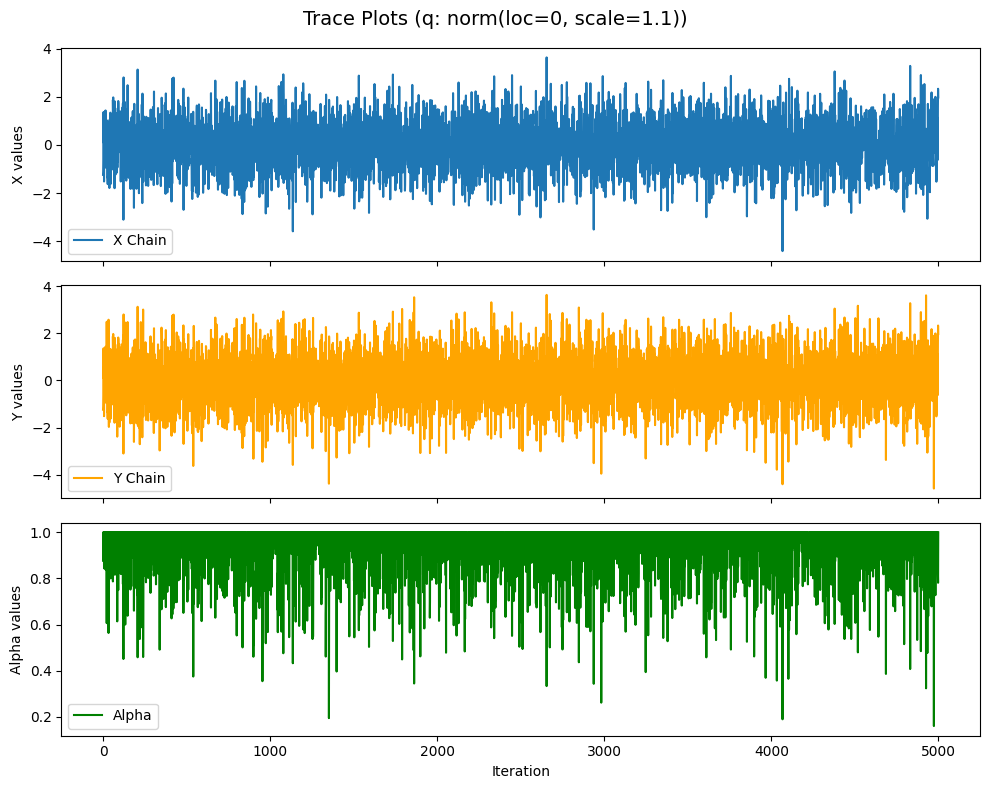

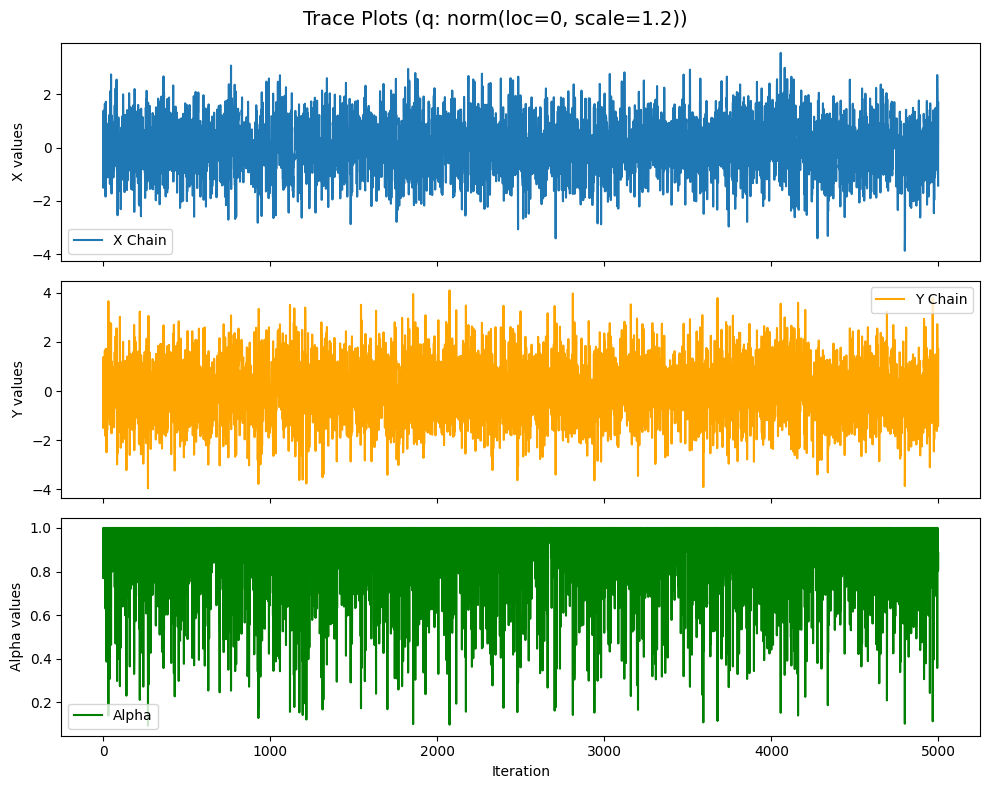

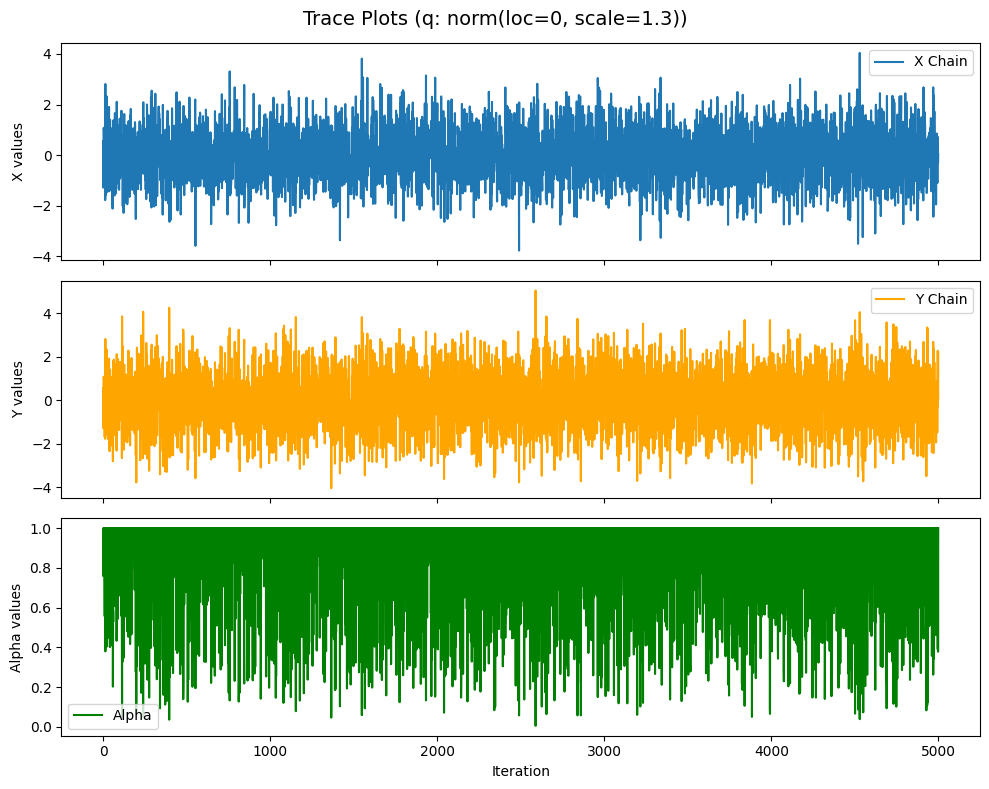

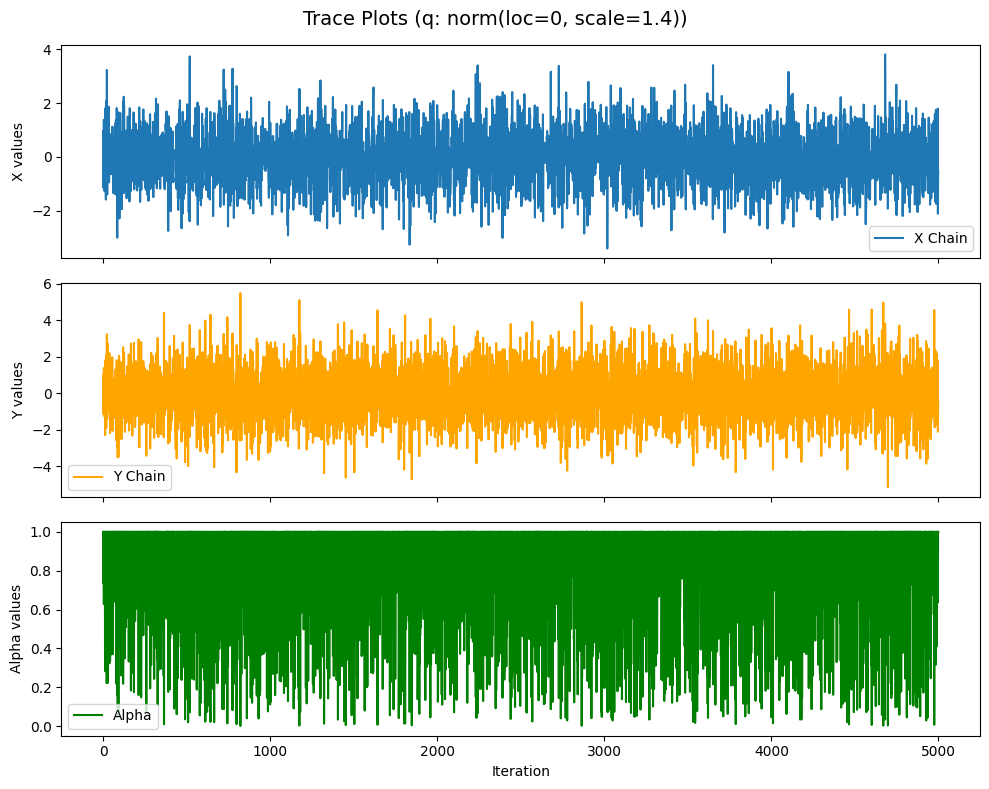

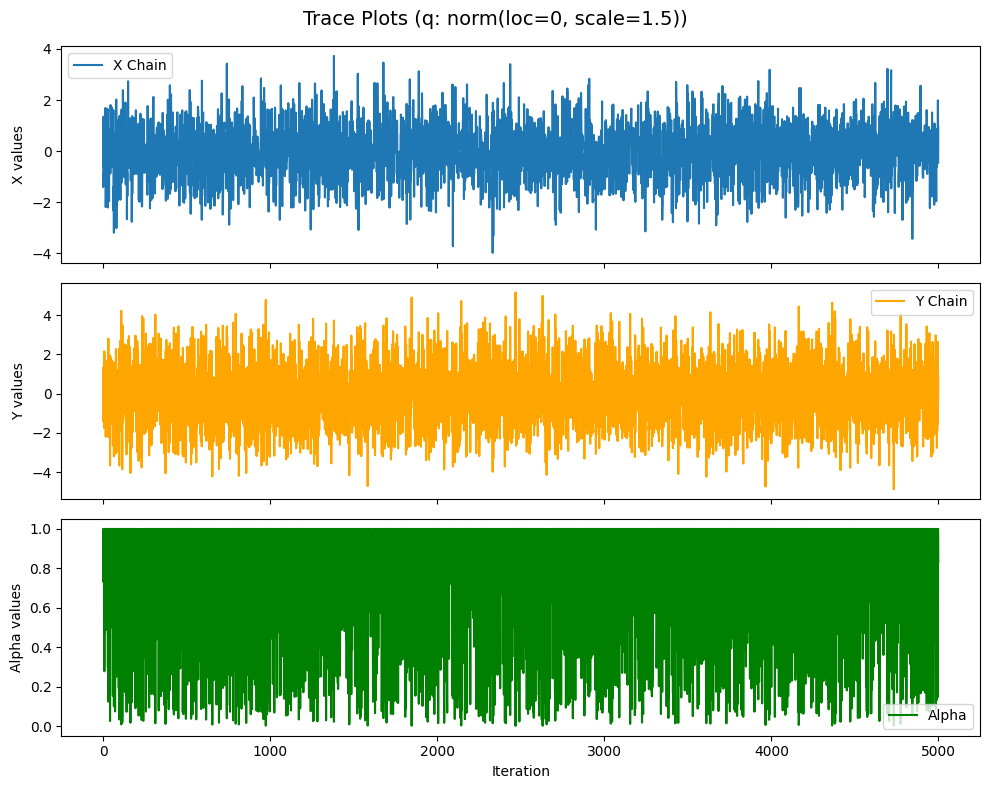

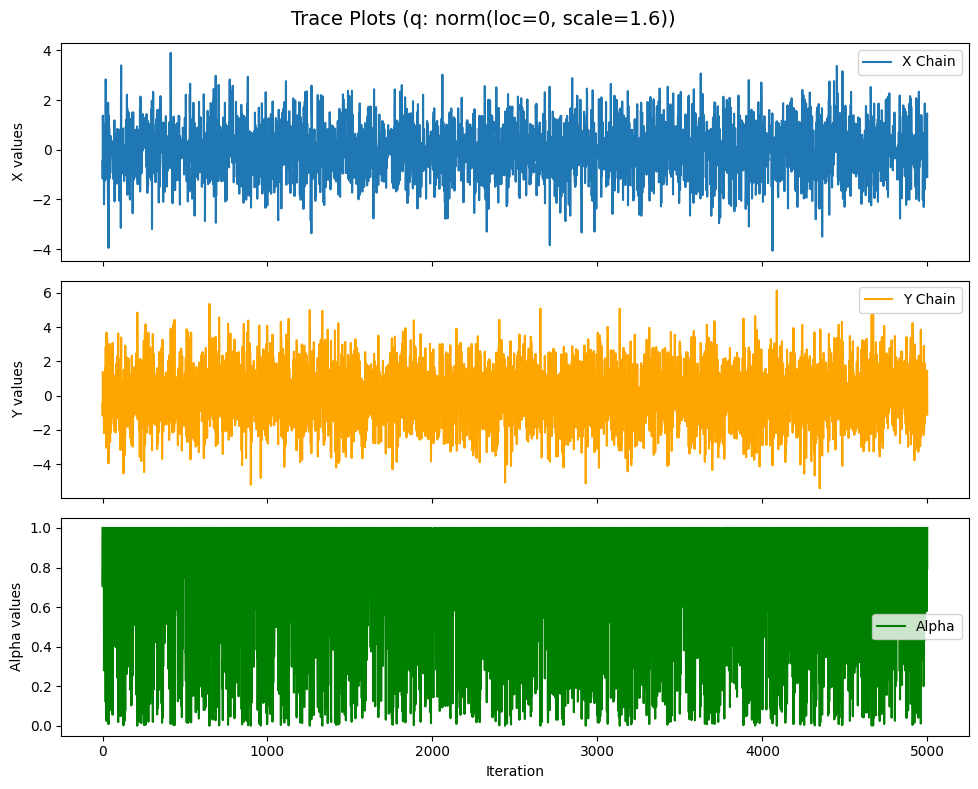

[[-0.004260803958280992, 0.0004612642319381338, -0.003534263776438204, 0.0008082977566006592, -0.0008341096968735407, 0.00010693976464860199, -0.0011271203291043086, -0.00396064817534027, 0.0018307890463781667, 0.0017206371817771362, -0.0001833597015105065, 0.003811662912315274, 0.0004168060614907871, 0.0034478238744887995, 0.0016204002794374085, 0.001532102566493471, -0.0024973682562503792, 0.0017207152644361037, -0.0010325029719968353, -0.0023056794010513928, 0.0012558838717662275, -0.0011992559777176165, -0.005876778097741654, -0.0010988942099946957, 0.0038784640441155956, -0.0014423936646724743, -0.005577543783400491, -0.0015301848951750192, 0.0055614336367396195, 0.0009223724789528636, -0.0014234887377180638, -8.008406182961685e-05, 0.0018757147967505123, 0.0039584896266516905, 0.00010798120556587412, 0.0012131609025300939, -0.003876708722786758, -0.003210686812628714, -0.001316914083009995, -0.0007322190839196145, -0.0007706995759446677, -0.003784253430278082, -0.0018202693370185

In [ ]:
 # Sigmas given in the paper
## Trying to recreate the graphs in the paper to make sure my implementation is correct
sigmas = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6]
IMCV_lists = []
MH_lists = []
VRF_list = []
T = 100
for k in sigmas:
  A = univariate_independent_metro(n_simulations = 5000, T_iterations = T, burn_in = 1000,
                               pi_distribution = scipy.stats.norm(loc = 0, scale = 1),
                               q_distribution = scipy.stats.norm(loc = 0, scale = k),
                               F_function = lambda x: x)
  IMCV_estimates = A[0]
  # It's not necessary to plot these, as they don't have them in the paper, but the more visualizations about how the chain performed, the better in my opinion
  plot_traces(A[1], A[2], A[3], q_distribution = scipy.stats.norm(loc = 0, scale = k))
  # mu_IMCV
  IMCV_lists.append(A[0])
  # mu_MC*
  ## Run symmetric MH
  B = univariate_symmetric_MH_sampler(n_simulations = 5000, T_iterations = T, burn_in = 1000,
                                      pi_distribution = scipy.stats.norm(loc = 0, scale = 1),
                                      F_function = lambda x: x)
  MC_estimates = B
  MH_lists.append(MC_estimates)
  # VRF calculation
  VRF_list.append(statistics.variance(MC_estimates)/statistics.variance(IMCV_estimates))

print(IMCV_lists)
print(MH_lists)

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2600862558.py:3: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel("$\sigma$")
/tmp/ipython-input-2600862558.py:8: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel("$\sigma$")
/tmp/ipython-input-2600862558.py:13: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel("$\sigma$")


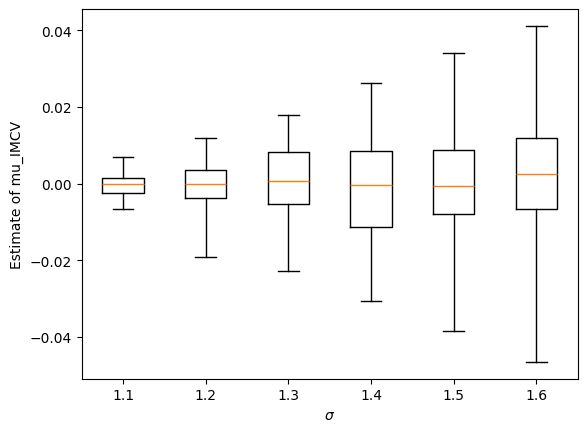

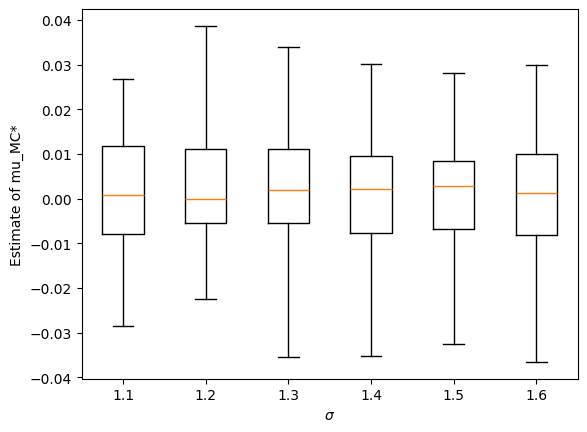

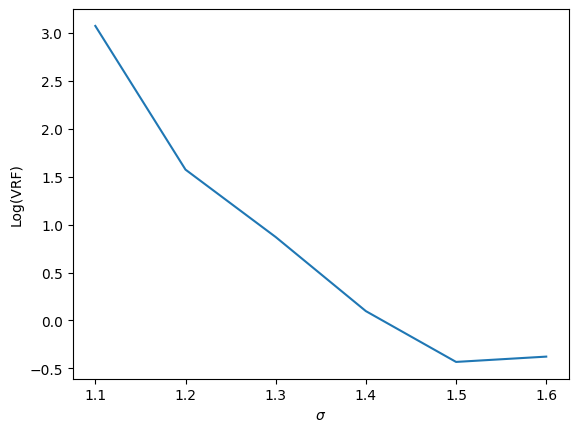

In [ ]:
# Plotting the mu_IMCV estimates. In paper
plt.boxplot(IMCV_lists, tick_labels = sigmas, showfliers=False, whis=[0, 100])
plt.xlabel("$\sigma$")
plt.ylabel("Estimate of mu_IMCV")
plt.show()
# Plotting the mu_MC* estimates. Not in the paper, but just for comparison
plt.boxplot(MH_lists, tick_labels = sigmas, showfliers=False, whis=[0, 100])
plt.xlabel("$\sigma$")
plt.ylabel("Estimate of mu_MC*")
plt.show()
# Haven't figured out how to calculate the bounds yet, but I have the curve of the base log(VRF) from the simulations
plt.plot(sigmas, [math.log(i) for i in VRF_list])
plt.xlabel("$\sigma$")
plt.ylabel("Log(VRF)")
plt.show()

[3.0314331330207964, 6.062866266041593, 12.125732532083186, 24.251465064166364, 48.50293012833273, 97.00586025666546]


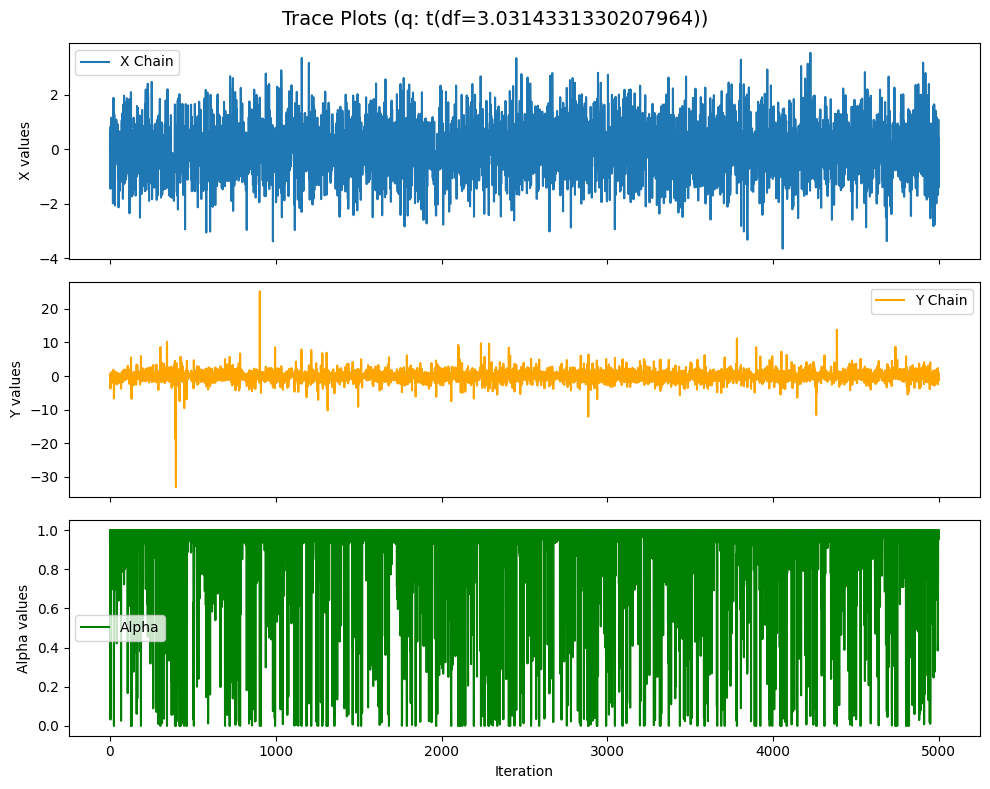

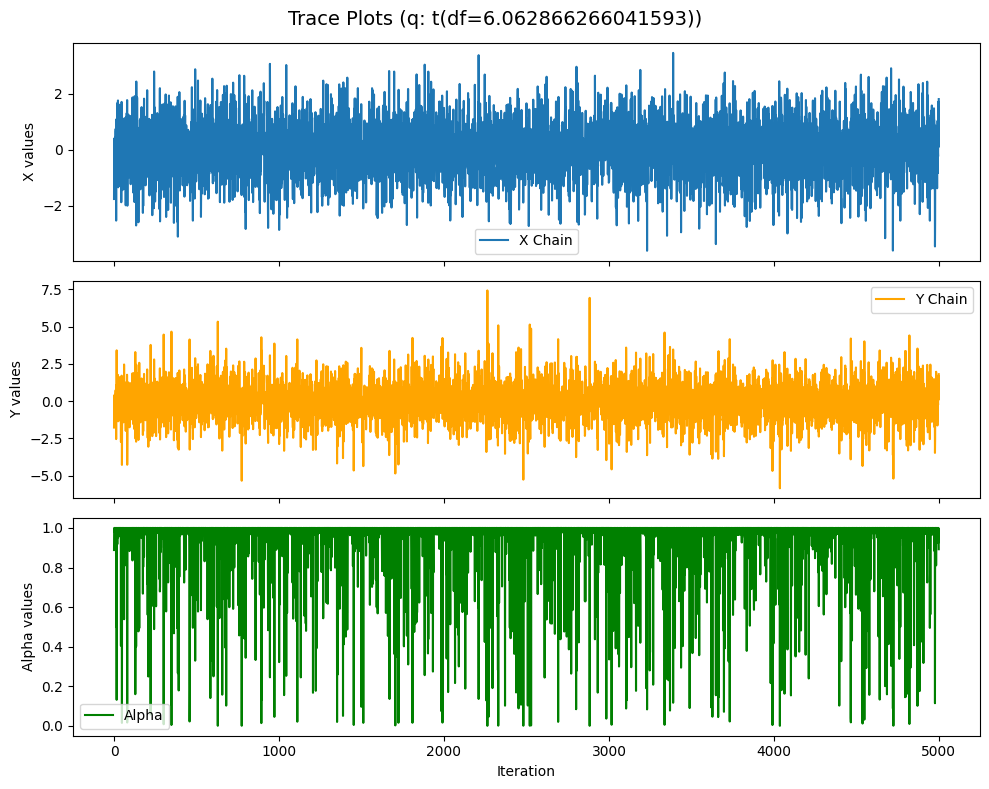

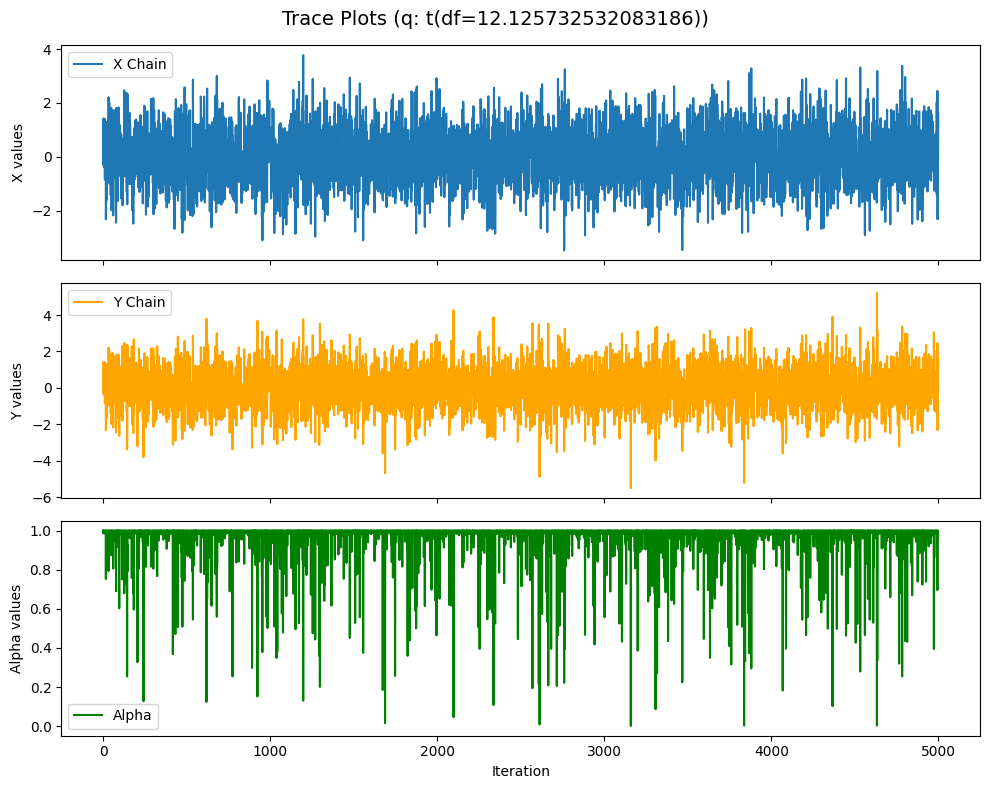

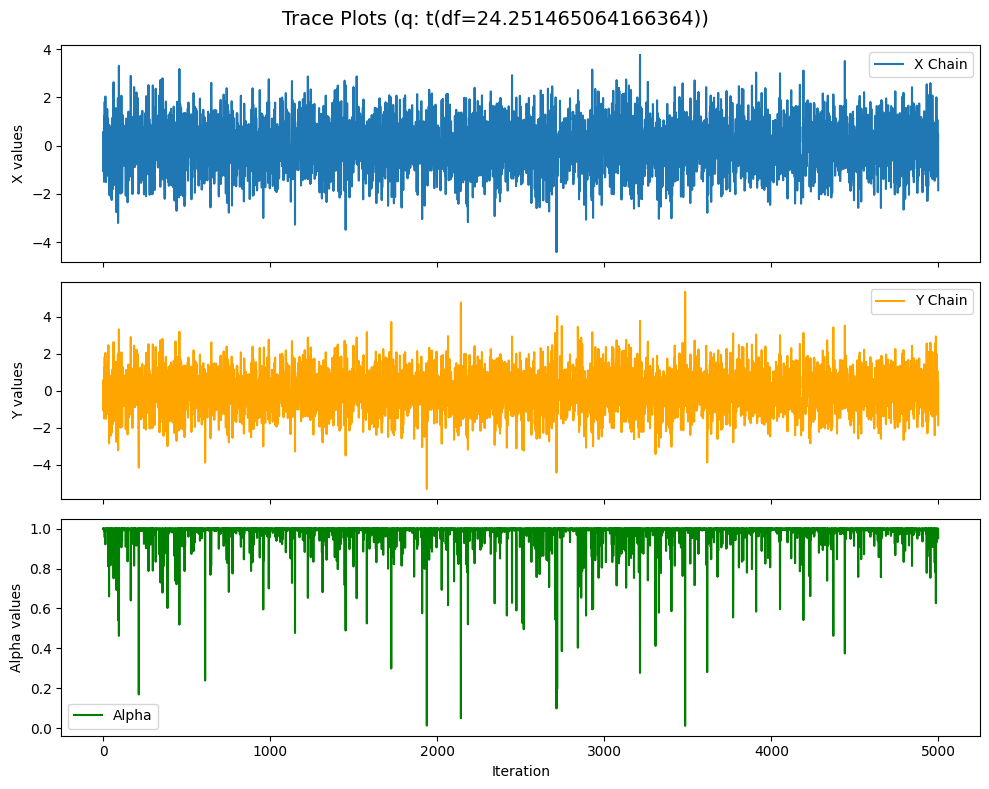

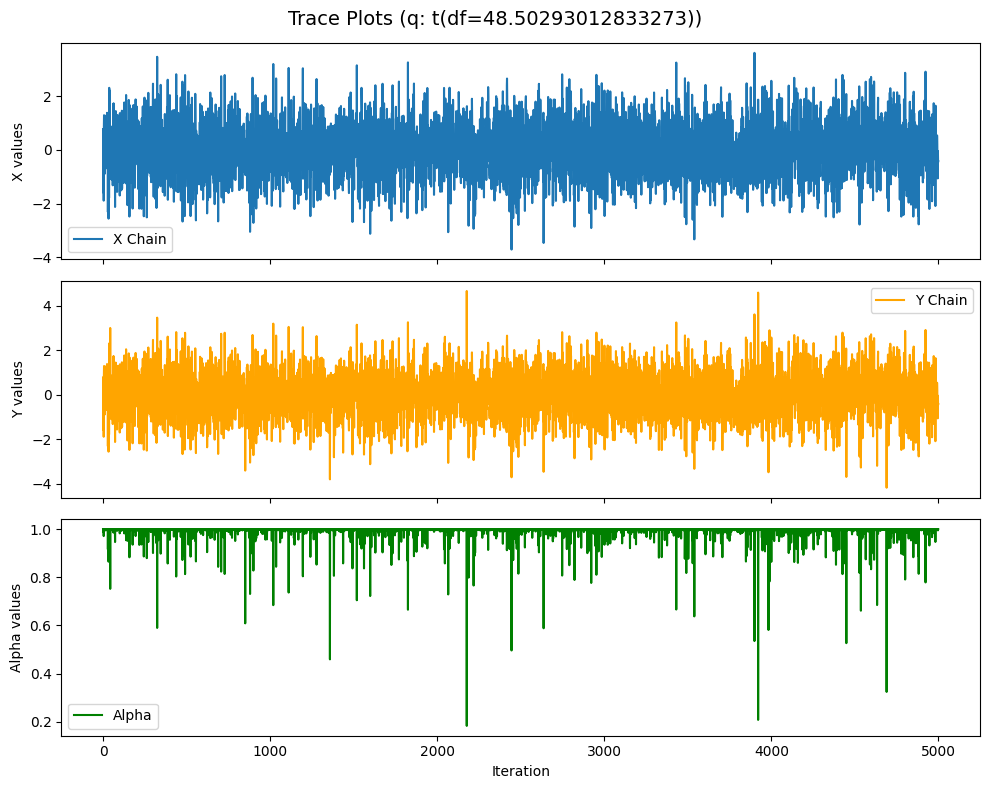

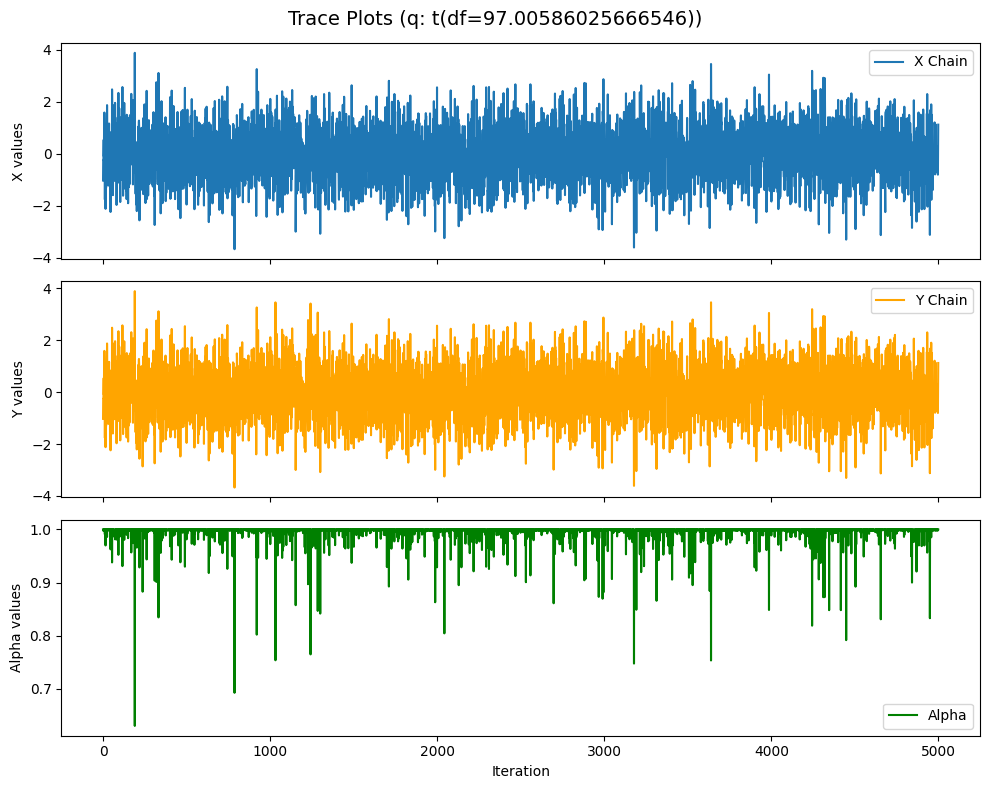

In [ ]:
# log_2 of v (degrees of freedom parameters for T-distribution) given in paper
log_2_v = [1.6, 2.6, 3.6, 4.6, 5.6, 6.6]
v = [2 ** i for i in log_2_v]
print(v)
IMCV_t_distribution_lists = []
MH_t_distribution_lists = []
VRF_t_distribution_lists = []
T = 100
for k in v:
  X = univariate_independent_metro(n_simulations = 5000, T_iterations = T, burn_in = 1000,
                               pi_distribution = scipy.stats.norm(loc = 0, scale = 1),
                               q_distribution = scipy.stats.t(df = k),
                               F_function = lambda x: x)
  plot_traces(X[1], X[2], X[3], q_distribution = scipy.stats.t(df = k))
  IMCV_t_distribution_lists.append(X[0])
  Y = univariate_symmetric_MH_sampler(n_simulations= 5000, T_iterations = T, burn_in = 1000,
                              pi_distribution=scipy.stats.norm(loc = 0, scale = 1),
                              F_function= lambda x: x)
  MH_t_distribution_lists.append(Y)
  VRF_t_distribution_lists.append(statistics.variance(Y)/statistics.variance(X[0]))

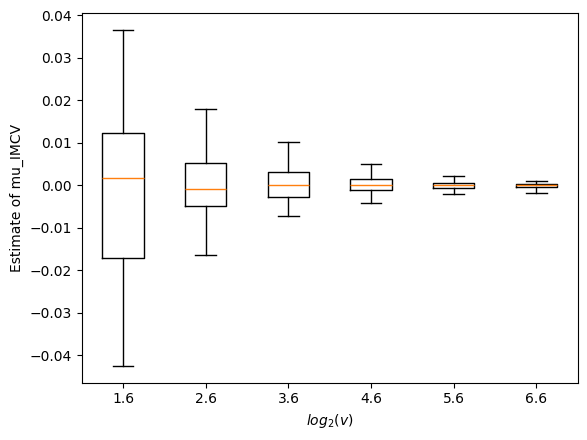

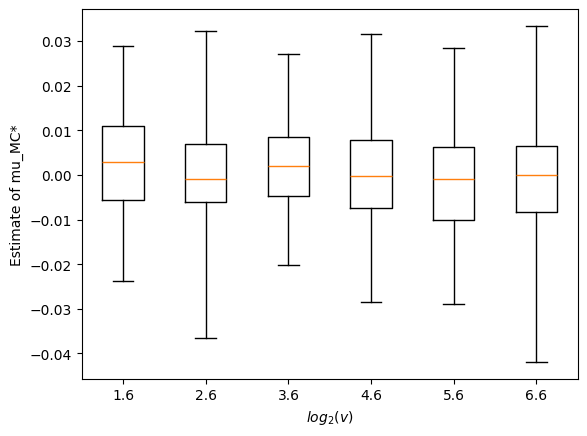

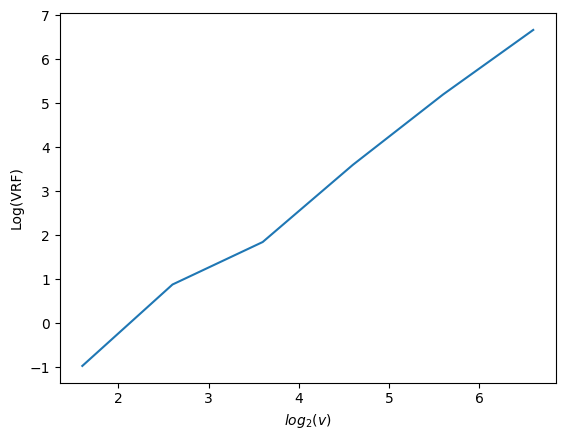

In [ ]:
plt.boxplot(IMCV_t_distribution_lists, tick_labels = log_2_v, showfliers=False, whis=[0, 100])
plt.xlabel("$log_2(v)$")
plt.ylabel("Estimate of mu_IMCV")
plt.show()

plt.boxplot(MH_t_distribution_lists, tick_labels = log_2_v, showfliers=False, whis=[0, 100])
plt.xlabel("$log_2(v)$")
plt.ylabel("Estimate of mu_MC*")
plt.show()

plt.plot(log_2_v, [math.log(i) for i in VRF_t_distribution_lists])
plt.xlabel("$log_2(v)$")
plt.ylabel("Log(VRF)")
plt.show()